# PPO

### Setup

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
import numpy as np

import random
import math
import time

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output


import gymnasium as gym
from gymnasium.wrappers import TransformObservation

In [3]:
def pytorch_env(env):
    env = TransformObservation(env, lambda x: torch.from_numpy(x), env.observation_space)
    return env

In [4]:
def update_plot(data, title="", xlabel="", ylabel="", grid=True, sleep=0.01):
    clear_output(wait=True)
    plt.plot(data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(grid)
    plt.show()
    time.sleep(sleep)

In [5]:
env = pytorch_env(gym.make('CartPole-v1'))

N_OBSERVATIONS = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n

TEST = False
TRAIN = True
SAVE = False

### Hyperparameters

In [59]:
# Hyperparameters
n_agents = 4
n_timesteps = 512
gamma = 0.999
epsilon = 0.1
h = 0.01 # Entropy constant
v = 1.0 # Value constant
learning_rate = 3e-4
batch_size = 64
n_epochs = 4
n_trainsteps = 100
max_grad_norm = 0.5
layer_dim = 128

### Model

In [7]:
class PolicyAndValueNetwork(nn.Module):
    def __init__(self, n_observations, n_actions, layer_dim):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(n_observations, layer_dim),
            nn.ReLU()
        )
        self.policy_head = nn.Sequential(
            nn.Linear(layer_dim, layer_dim),
            nn.ReLU(),
            nn.Linear(layer_dim, n_actions)
        )
        self.value_head = nn.Sequential(
            nn.Linear(layer_dim, layer_dim),
            nn.ReLU(),
            nn.Linear(layer_dim, 1)
        )

    def forward(self, x):
        shared_output = self.shared_layers(x)
        action_logits = self.policy_head(shared_output)
        value = self.value_head(shared_output)
        return torch.cat([action_logits, value], dim=-1)

### Select action

Select action based on action logits.

In [8]:
def select_action(action_logits):
    action_probs = torch.softmax(action_logits, dim=0)
    action = torch.multinomial(action_probs, num_samples=1).item()
    return action

### Test model

In [9]:
def test_model(model):
	test_env = gym.make('CartPole-v1')
	test_env = pytorch_env(test_env)
	episode_reward = 0.
	state, _ = test_env.reset()
	terminated, truncated = False, False
	while not (terminated or truncated):
		with torch.no_grad():
			logits = model(state)
		action_logits = logits[:-1]
		action = select_action(action_logits)
		state, reward, terminated, truncated, _ = test_env.step(action)
		episode_reward += reward
	return episode_reward

### PPO Dataset

In [10]:
class PPODataset(Dataset):
	def __init__(self, n_agents, n_timesteps, n_observations, n_actions, gamma):
		# Store variables
		self.n_agents = n_agents
		self.n_timesteps = n_timesteps
		self.n_observations = n_observations
		self.n_actions = n_actions
		self.gamma = gamma

		# Create tensors
		self.states = torch.zeros((n_agents, n_timesteps, n_observations))
		self.actions = torch.zeros((n_agents, n_timesteps), dtype=torch.int)
		self.rewards = torch.zeros((n_agents, n_timesteps))
		self.logprobs = torch.zeros((n_agents, n_timesteps, n_actions))
		self.pred_values = torch.zeros((n_agents, n_timesteps))
		self.target_values = torch.zeros((n_agents, n_timesteps))
		self.advantages = torch.zeros((n_agents, n_timesteps))

		# Store episode ends
		self.episode_ends = [[] for _ in range(n_agents)]

	def add_step(self, agent, t, state, action, reward, logprob, pred_value):
		self.states[agent, t] = state
		self.actions[agent, t] = action
		self.rewards[agent, t] = reward
		self.logprobs[agent, t] = logprob
		self.pred_values[agent, t] = pred_value

	def mark_episode_end(self, agent, t):
		self.episode_ends[agent].append(t)

	def __compute_advantages_and_target_values(self):
		for agent in range(self.n_agents):
			# Iterate from last to first
			for t in range(self.n_timesteps-1, -1, -1):
				# Get reward and predicted value
				reward = self.rewards[agent, t]
				pred_value = self.pred_values[agent, t]

				# If step is terminal (end of episode)
				if t in self.episode_ends[agent]:
					target_value = reward
				# If step is last (t = n_timesteps - 1) but not terminal
				elif t == self.n_timesteps - 1:
					target_value = pred_value
				# non-terminal non-last step
				else:
					# Get previous target value (of t+1) and compute
					previous_target_value = self.target_values[agent][t+1]
					target_value = reward + self.gamma * previous_target_value
				
				# Compute advantage
				advantage = target_value - pred_value

				# Store target value and advantage
				self.target_values[agent, t] = target_value
				self.advantages[agent, t] = advantage

	def __flatten_data(self):
		# Flatten all tensors that will be fetched
		self.states = self.states.view(-1, self.n_observations)
		self.actions = self.actions.view(-1)
		self.logprobs = self.logprobs.view(-1, self.n_actions)
		self.target_values = self.target_values.view(-1)
		self.advantages = self.advantages.view(-1)

	def compute_advantages_and_target_values_and_flatten_data(self):
		self.__compute_advantages_and_target_values()
		self.__flatten_data()

	def __len__(self):
		return self.n_agents * self.n_timesteps
	
	def __getitem__(self, i):
		# Don't use before calling compute_advantages_and_target_values and flatten_data
		state = self.states[i]
		action = self.actions[i]
		logprob = self.logprobs[i]
		target_value = self.target_values[i]
		advantage = self.advantages[i]

		return state, action, logprob, target_value, advantage

### Loss function(s)

In [11]:
def clipped_objective_fn(pred_logprob, logprob_batch, action_batch, advantage_batch, epsilon):
    # Compute new logprobs
    pred_logprob_batch = pred_logprob[torch.arange(len(action_batch)), action_batch]
    
	# Format old logprob
    old_logprob_batch = logprob_batch[torch.arange(len(action_batch)), action_batch]

    # Compute p_ratio, ratio of new and old probabilities
    p_ratio = torch.exp(pred_logprob_batch - old_logprob_batch)

    # Compute unclipped and clipped surrogate objectives
    unclipped_surrogate_objective = p_ratio * advantage_batch
    clipped_surrogate_objective = torch.clamp(p_ratio, 1. - epsilon, 1. + epsilon) * advantage_batch

    # Compute elementwise minimum of two and return
    clipped_objective = torch.mean(torch.min(unclipped_surrogate_objective, clipped_surrogate_objective))
    return clipped_objective

In [12]:
def entropy_bonus_fn(log_probs):
    # Compute probabilities
    probs = torch.exp(log_probs)

    # Compute and return entropy
    entropy = -torch.mean(torch.sum(probs * log_probs, dim=-1))
    return entropy

In [13]:
def value_loss_fn(pred_values, target_value_batch):
    # Compute and return loss
    smoothl1 = nn.SmoothL1Loss(reduction='mean')
    loss = smoothl1(pred_values, target_value_batch)
    return loss

In [14]:
def loss_fn(model, state_batch, action_batch, logprob_batch, target_value_batch, advantage_batch, epsilon, v, h):
    # Get pred log probs and values
    output = model(state_batch)
    pred_logprob_batch = torch.log_softmax(output[:, :-1], dim=-1)
    pred_value_batch = output[:, -1]

    # Compute individual losses
    clipped_objective = clipped_objective_fn(pred_logprob_batch, logprob_batch, action_batch, advantage_batch, epsilon)
    value_loss = value_loss_fn(pred_value_batch, target_value_batch)
    entropy_bonus = entropy_bonus_fn(pred_logprob_batch)

    # Compute and return total loss
    loss = -clipped_objective + v * value_loss - h * entropy_bonus
    return loss

### Train loop

Add something that copies environments

In [15]:
def train_loop(model, optimizer, batch_size, n_epochs, n_trainsteps, n_agents, n_timesteps, n_observations, n_actions, gamma, epsilon, v, h, max_grad_norm):
	# Initialize rewards and losses
	rewards = []
	losses = []

	# Initilize all environments
	envs = []
	for agent in range(n_agents):
		env = gym.make('CartPole-v1')
		env = pytorch_env(env)
		state, _ = env.reset()
		terminated, truncated = False, False
		envs.append([env, state, terminated, truncated])
			
	for _ in range(n_trainsteps):
		# Initialize dataset
		dataset = PPODataset(n_agents, n_timesteps, n_observations, n_actions, gamma)

		# Collect data
		with torch.no_grad():
			for agent in range(n_agents):
				env = envs[agent][0]
				state, terminated, truncated = envs[agent][1:]
	
				for t in range(n_timesteps):
					# Compute and split model output
					output = model(state)
					action_logits = output[:-1]
					pred_value = output[-1]

					# Select and perform action
					action = select_action(action_logits)
					next_state, reward, terminated, truncated, _ = env.step(action)

					# Compute logprob
					logprob = torch.log_softmax(action_logits, dim=-1)[action]

					# Store data
					dataset.add_step(agent, t, state, action, reward, logprob, pred_value)

					# If terminated reset env and mark end, otherwise update state
					if terminated or truncated:
						dataset.mark_episode_end(agent, t)
						state, _ = env.reset()
						terminated, truncated = False, False
					else:
						state = next_state

		# Compute target values and advantages and flatten data
		dataset.compute_advantages_and_target_values_and_flatten_data()

		# Create dataloader
		dataloader = DataLoader(
			dataset=dataset,
			batch_size=batch_size,
			shuffle=True,
		)

		# Train model on policy for N_EPOCHS
		for _ in range(n_epochs):
			for state_batch, action_batch, logprob_batch, target_value_batch, advantage_batch in dataloader:
				# Compute loss and optimize
				loss = loss_fn(
					model,
					state_batch,
					action_batch,
					logprob_batch,
					target_value_batch,
					advantage_batch,
					epsilon,
					v,
					h,
				)
				loss.backward()
				# Clip gradients
				clip_grad_norm_(model.parameters(), max_grad_norm)
				optimizer.step()
				optimizer.zero_grad()

				# Append losses
				losses.append(loss.item())

		# Test model, append reward and display
		test_reward = test_model(model)
		rewards.append(test_reward)
		update_plot(rewards, "Test rewards", "Reward", "Train loop")

	return rewards, losses

### Train

In [60]:
model = PolicyAndValueNetwork(N_OBSERVATIONS, N_ACTIONS, layer_dim)
optimizer = optim.Adam(model.parameters())

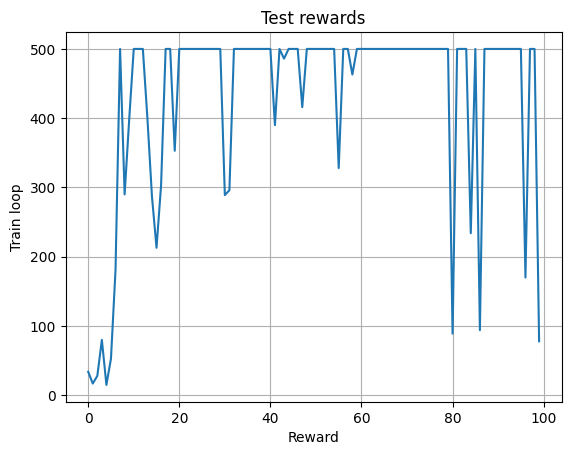

In [61]:
if TRAIN:
    rewards, losses = train_loop(
        model,
        optimizer,
        batch_size,
        n_epochs,
        n_trainsteps,
        n_agents,
        n_timesteps,
        N_OBSERVATIONS,
        N_ACTIONS,
        gamma,
        epsilon,
        v,
        h,
        max_grad_norm,
	)

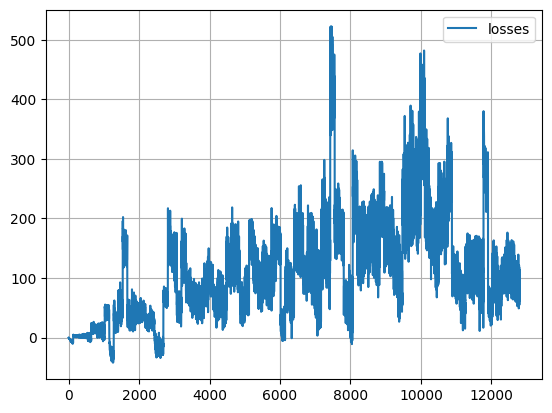

In [62]:
plt.plot(losses, label="losses")
plt.legend()
plt.grid(True)
plt.show()

In [63]:
test_env = gym.make('CartPole-v1', render_mode='human')
test_env = pytorch_env(test_env)
episode_reward = 0.
state, _ = test_env.reset()
terminated, truncated = False, False
while not (terminated or truncated):
	with torch.no_grad():
		logits = model(state)
	action_logits = logits[:-1]
	action = select_action(action_logits)
	state, reward, terminated, truncated, _ = test_env.step(action)
	episode_reward += reward
test_env.close()
print(episode_reward)

500.0
